In [1]:
import os

os.environ['KAGGLE_USERNAME'] = "your username"
os.environ['KAGGLE_KEY'] = "your api token"

In [2]:
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d programmerrdai/road-issues-detection-dataset -p /content/ --force

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/programmerrdai/road-issues-detection-dataset
License(s): MIT
 96% 456M/477M [00:00<00:00, 394MB/s]
100% 477M/477M [00:01<00:00, 464MB/s]


In [4]:
!unzip road-issues-detection-dataset.zip -d /content/

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /content/data/Road Issues/Broken Road Sign Issues/IMG_8900_jpg.rf.13bcd30e9809897a6b868e8b4f9a346a.jpg  
  inflating: /content/data/Road Issues/Broken Road Sign Issues/IMG_8900_jpg.rf.3f73bb0e0fb0a020df43354dfda1e469.jpg  
  inflating: /content/data/Road Issues/Broken Road Sign Issues/IMG_8900_jpg.rf.820c959237e9c19abf619aa0c76a140e.jpg  
  inflating: /content/data/Road Issues/Broken Road Sign Issues/IMG_8901_jpg.rf.4dfce4d95f22be6b03a37b8a05ee4ed5.jpg  
  inflating: /content/data/Road Issues/Broken Road Sign Issues/IMG_8901_jpg.rf.954ac1fe0615b637515385d4a0afa138.jpg  
  inflating: /content/data/Road Issues/Broken Road Sign Issues/IMG_8901_jpg.rf.c2875fd200b3e7af296151a099fe4479.jpg  
  inflating: /content/data/Road Issues/Broken Road Sign Issues/IMG_8902_jpg.rf.373e7fa195c542807d78b793dacf5ba0.jpg  
  inflating: /content/data/Road Issues/Broken Road Sign Issues/IMG_8902_jpg.rf.dc4789c4c3ab32b18332cb931c854340.jpg

In [16]:
import os
import pandas as pd

base_dir = "/content/data"

image_paths = []
labels = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            full_path = os.path.join(root, file)

            # label = nama folder terakhir
            label = os.path.basename(root)

            image_paths.append(full_path)
            labels.append(label)

df = pd.DataFrame({
    "filename": image_paths,
    "class": labels
})

print(df.head())
print(df['class'].value_counts())


                                            filename           class
0  /content/data/Road Issues/Pothole Issues/597_j...  Pothole Issues
1  /content/data/Road Issues/Pothole Issues/573_j...  Pothole Issues
2  /content/data/Road Issues/Pothole Issues/230_j...  Pothole Issues
3  /content/data/Road Issues/Pothole Issues/476_j...  Pothole Issues
4  /content/data/Road Issues/Pothole Issues/379_j...  Pothole Issues
class
Pothole Issues                               3348
Vandalism Issues                             2128
Broken Road Sign Issues                      1793
Littering Garbage on Public Places Issues    1419
Damaged Road issues                           677
Mixed Issues                                  191
Illegal Parking Issues                        104
Name: count, dtype: int64


# Encode Label

In [17]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['class'],
    random_state=42
)

print(train_df.shape, val_df.shape)


(7728, 2) (1932, 2)


# Data Generator

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (64, 64)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

CLASS_NAMES = list(train_data.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)

print(CLASS_NAMES)


Found 7728 validated image filenames belonging to 7 classes.
Found 1932 validated image filenames belonging to 7 classes.
['Broken Road Sign Issues', 'Damaged Road issues', 'Illegal Parking Issues', 'Littering Garbage on Public Places Issues', 'Mixed Issues', 'Pothole Issues', 'Vandalism Issues']


# CNN Baseline

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

def cnn_baseline(input_shape=(64,64,3), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    # ===== Block 1 =====
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.AveragePooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    # ===== Block 2 =====
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.AveragePooling2D((2,2))(x)

    # ===== Block 3 =====
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.AveragePooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    # ===== Classifier =====
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)


# Model Trasnfer Learning

DenseNet-201

In [20]:
from tensorflow.keras.applications import DenseNet201

def densenet201_model(num_classes):
    base = DenseNet201(weights='imagenet', include_top=False,
                       input_shape=(64,64,3))
    base.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(base.input, output)


**VGG-16**

In [21]:
from tensorflow.keras.applications import VGG16

def vgg16_model(num_classes):
    base = VGG16(weights='imagenet', include_top=False,
                 input_shape=(64,64,3))
    base.trainable = False

    x = layers.Flatten()(base.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(base.input, output)


# Training

In [22]:
import tensorflow as tf

def train_and_save(model, name):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=30
    )

    model.save(f"saved_models/{name}.h5")
    return history


In [23]:
cnn_model = cnn_baseline(num_classes=NUM_CLASSES)
hist_cnn = train_and_save(cnn_model, "cnn_baseline")

dn_model = densenet201_model(NUM_CLASSES)
hist_dn = train_and_save(dn_model, "densenet201")

vgg_model = vgg16_model(NUM_CLASSES)
hist_vgg = train_and_save(vgg_model, "vgg16")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.5212 - loss: 1.9406 - val_accuracy: 0.3297 - val_loss: 7.7227
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.7134 - loss: 0.8838 - val_accuracy: 0.6687 - val_loss: 1.3373
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.7561 - loss: 0.7751 - val_accuracy: 0.6744 - val_loss: 1.1604
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.7786 - loss: 0.6741 - val_accuracy: 0.6553 - val_loss: 1.4344
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.8037 - loss: 0.6096 - val_accuracy: 0.7743 - val_loss: 0.7357
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.8186 - loss: 0.5659 - val_accuracy: 0.7164 - val_loss: 1.0738
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.8171 - loss: 0.5415 - val_accuracy: 0.6806 - val_loss: 1.2849
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.8317 - loss: 0.5147 - val_accu

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.6876 - loss: 1.1235 - val_accuracy: 0.8468 - val_loss: 0.4589
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.8460 - loss: 0.5082 - val_accuracy: 0.8597 - val_loss: 0.4257
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 242s 999ms/step - accuracy: 0.8642 - loss: 0.4175 - val_accuracy: 0.8810 - val_loss: 0.3650
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 241s 997ms/step - accuracy: 0.8794 - loss: 0.3835 - val_accuracy: 0.8716 - val_loss: 0.3896
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 262s 996ms/step - accuracy: 0.8837 - loss: 0.3617 - val_accuracy: 0.8908 - val_loss: 0.3540
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.8832 - loss: 0.3493 - val_accuracy: 0.8939 - val_loss: 0.3370
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.8901 - loss: 0.3362 - val_accuracy: 0.8820 - val_loss: 0.3531
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.6530 - loss: 0.9963 - val_accuracy: 0.8297 - val_loss: 0.5455
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.8088 - loss: 0.5922 - val_accuracy: 0.8478 - val_loss: 0.4757
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.8226 - loss: 0.5304 - val_accuracy: 0.8297 - val_loss: 0.4971
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.8390 - loss: 0.4905 - val_accuracy: 0.8618 - val_loss: 0.4359
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.8472 - loss: 0.4743 - val_accuracy: 0.8613 - val_loss: 0.4288
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.8539 - loss: 0.4399 - val_accuracy: 0.8628 - val_loss: 0.4013
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.8538 - loss: 0.4180 - val_accuracy: 0.8737 - val_loss: 0.3897
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 591s 2

# Evaluasi

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, model_name="Model"):
    val_data.reset()   # ⬅️ WAJIB

    preds = model.predict(val_data, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_data.classes

    print(f"\n===== Evaluation Result: {model_name} =====")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES,
        cmap="Blues"
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step

===== Evaluation Result: CNN Baseline =====
                                           precision    recall  f1-score   support

                  Broken Road Sign Issues       0.98      0.88      0.93       359
                      Damaged Road issues       0.85      0.47      0.61       135
                   Illegal Parking Issues       0.85      0.52      0.65        21
Littering Garbage on Public Places Issues       0.93      0.88      0.91       284
                             Mixed Issues       0.00      0.00      0.00        38
                           Pothole Issues       0.83      0.99      0.90       669
                         Vandalism Issues       0.85      0.91      0.88       426

                                 accuracy                           0.87      1932
                                macro avg       0.76      0.66      0.70      1932
                             weighted avg       0.86      0.87      0.86      193

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


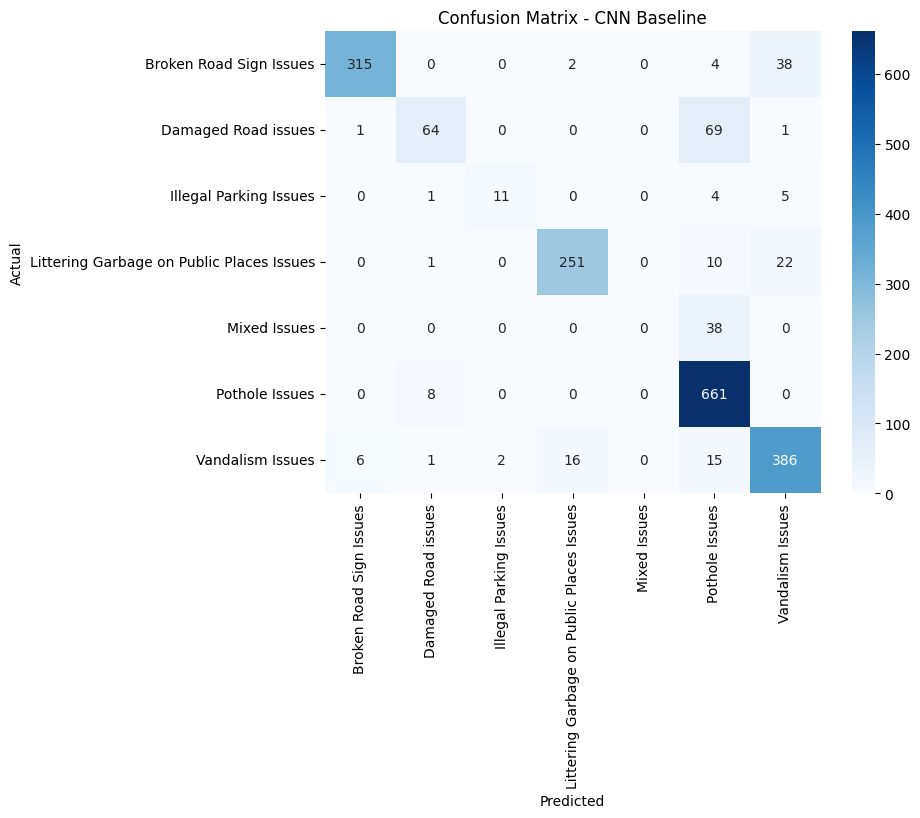

61/61 ━━━━━━━━━━━━━━━━━━━━ 63s 891ms/step

===== Evaluation Result: DenseNet-201 =====
                                           precision    recall  f1-score   support

                  Broken Road Sign Issues       0.95      0.99      0.97       359
                      Damaged Road issues       0.92      0.61      0.73       135
                   Illegal Parking Issues       1.00      0.57      0.73        21
Littering Garbage on Public Places Issues       0.87      0.94      0.90       284
                             Mixed Issues       1.00      0.05      0.10        38
                           Pothole Issues       0.87      0.99      0.92       669
                         Vandalism Issues       0.94      0.85      0.89       426

                                 accuracy                           0.90      1932
                                macro avg       0.94      0.71      0.75      1932
                             weighted avg       0.91      0.90      0.89      193

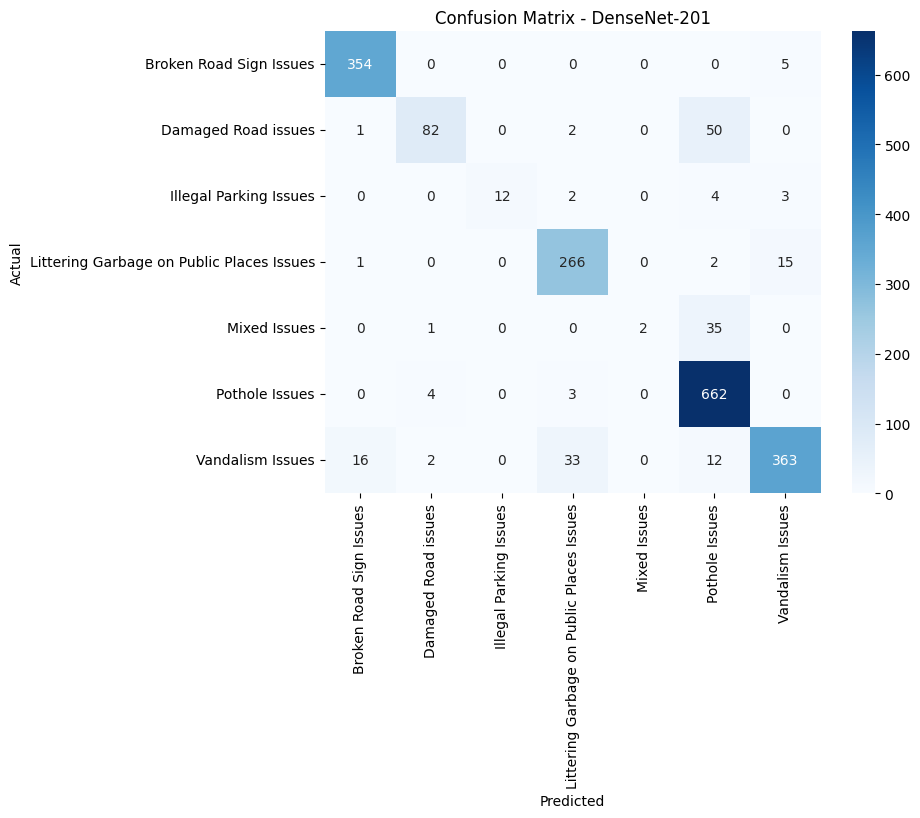

61/61 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step

===== Evaluation Result: VGG-16 =====
                                           precision    recall  f1-score   support

                  Broken Road Sign Issues       0.96      0.97      0.97       359
                      Damaged Road issues       0.69      0.67      0.68       135
                   Illegal Parking Issues       1.00      0.57      0.73        21
Littering Garbage on Public Places Issues       0.83      0.95      0.89       284
                             Mixed Issues       0.33      0.05      0.09        38
                           Pothole Issues       0.89      0.94      0.91       669
                         Vandalism Issues       0.94      0.85      0.89       426

                                 accuracy                           0.89      1932
                                macro avg       0.81      0.71      0.74      1932
                             weighted avg       0.88      0.89      0.88      1932



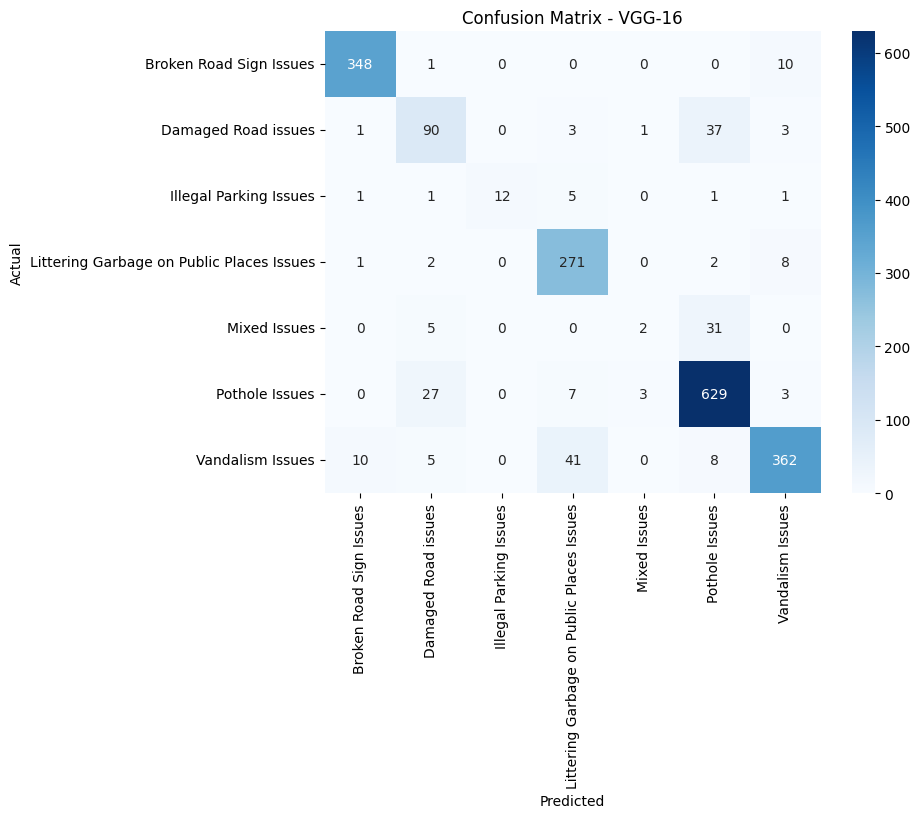

In [27]:
evaluate_model(cnn_model, "CNN_Baseline")
evaluate_model(dn_model, "DenseNet-201")
evaluate_model(vgg_model, "VGG-16")
